In [20]:
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


This is the notebook for some data exploration, feature selection, and model experimentation to predict which hallmark genes are associated with which tumor stage of cancer. 

In [0]:
import numpy as np
import pandas as pd
import gzip, shutil

In [0]:
path = '/content/drive/My Drive/MyDrive/Cancer Analysis/'
file_x = path + 'X.csv'
file_y = 'y.csv'
rnaseq_x = pd.read_csv(file_x)
tumor_y = pd.read_csv(file_y)

In [45]:
rnaseq_x.head()

,Unnamed: 0,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,AACSL,AACS,AADACL2,AADACL3,AADACL4,AADAC,AADAT,AAGAB,AAK1,AAMP,AANAT,AARS2,AARSD1,AARS,AASDHPPT,AASDH,AASS,AATF,AATK,ABAT,ABCA10,ABCA11P,ABCA12,ABCA13,ABCA17P,ABCA1,ABCA2,ABCA3,ABCA4,...,ZRANB1,ZRANB2,ZRANB3,ZRSR2,ZSCAN10,ZSCAN12P1,ZSCAN12,ZSCAN16,ZSCAN18,ZSCAN1,ZSCAN20,ZSCAN21,ZSCAN22,ZSCAN23,ZSCAN29,ZSCAN2,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSWIM1,ZSWIM2,ZSWIM3,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM7,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
0,tcga-2v-a95s-0,22283,584,0,375,0,286320,81,543,1,1032,0,558,0,0,0,1364,25,1068,690,3207,0,341,848,7024,1225,144,48,1542,62,1535,155,65,0,0,2,1151,1678,93,109,...,902,1335,26,229,2,39,60,134,95,0,24,152,112,0,405,451,0,95,2,127,0,101,136,277,181,413,210,305,213,464,25,274,795,19,500,3173,891,511,4,7
1,tcga-2y-a9gs-1,22642,1573,3,99,0,31169,163,2,1,903,0,431,0,1,0,10365,156,1058,542,3148,1,682,885,8495,977,160,450,2002,17,11220,22,23,1,19,2,1249,1126,74,50,...,682,1403,95,155,1,46,68,104,323,1,67,366,145,1,553,583,2,47,2,268,0,143,138,874,173,153,127,677,542,629,69,633,1154,72,1001,5302,756,861,7,483
2,tcga-2y-a9gt-2,77670,1281,0,215,1,19515,119,1,3,773,0,131,0,0,0,6959,479,523,510,2211,0,483,349,3542,806,165,3014,842,24,12577,36,30,1,26,0,3133,2186,70,25,...,2211,1211,56,113,0,33,45,78,174,0,6,242,99,4,417,190,0,49,2,138,0,125,119,9,196,183,91,399,177,287,47,1220,1134,13,1290,3220,861,524,15,84
3,tcga-2y-a9gu-3,9323,1253,0,2914,2,243941,72,0,0,722,0,706,0,0,0,6782,36,394,1568,1739,0,493,462,5918,748,184,1389,825,14,9671,55,109,0,4,7,1748,246,452,14,...,809,969,62,93,1,31,41,70,71,1,8,407,126,2,357,403,0,139,3,255,0,109,68,64,330,323,115,433,330,451,19,286,1151,10,942,3093,1340,344,3,3
4,tcga-2y-a9gv-4,84243,1641,0,404,0,8756,83,0,9,828,0,94,1,0,0,7106,616,614,536,1936,0,819,456,6088,815,253,698,894,43,23069,19,35,0,13,2,2885,1129,110,39,...,1312,1684,90,168,1,119,98,119,593,0,10,298,155,1,385,239,0,55,2,198,0,86,94,2,234,180,103,642,137,100,42,1000,1632,5,1381,2903,576,666,3,120


In [46]:
tumor_y.head()

,Unnamed: 0,tumor_stage
0,tcga-2v-a95s-0,ii
1,tcga-2y-a9gs-1,not_reported
2,tcga-2y-a9gt-2,i
3,tcga-2y-a9gu-3,i
4,tcga-2y-a9gv-4,i


In [0]:
#Renaming the Unnamed: 0 column to bcr_patient_barcode and setting that 
#to be the index for both datasets 
rnaseq_x = rnaseq_x.rename(columns={'Unnamed: 0': 'bcr_patient_barcode'})
rnaseq_x = rnaseq_x.set_index('bcr_patient_barcode')
tumor_y = tumor_y.rename(columns={'Unnamed: 0': 'bcr_patient_barcode'})
tumor_y = tumor_y.set_index('bcr_patient_barcode')

In [37]:
rnaseq_x.head()

,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,AACSL,AACS,AADACL2,AADACL3,AADACL4,AADAC,AADAT,AAGAB,AAK1,AAMP,AANAT,AARS2,AARSD1,AARS,AASDHPPT,AASDH,AASS,AATF,AATK,ABAT,ABCA10,ABCA11P,ABCA12,ABCA13,ABCA17P,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZRANB1,ZRANB2,ZRANB3,ZRSR2,ZSCAN10,ZSCAN12P1,ZSCAN12,ZSCAN16,ZSCAN18,ZSCAN1,ZSCAN20,ZSCAN21,ZSCAN22,ZSCAN23,ZSCAN29,ZSCAN2,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSWIM1,ZSWIM2,ZSWIM3,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM7,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tcga-2v-a95s-0,22283,584,0,375,0,286320,81,543,1,1032,0,558,0,0,0,1364,25,1068,690,3207,0,341,848,7024,1225,144,48,1542,62,1535,155,65,0,0,2,1151,1678,93,109,1219,...,902,1335,26,229,2,39,60,134,95,0,24,152,112,0,405,451,0,95,2,127,0,101,136,277,181,413,210,305,213,464,25,274,795,19,500,3173,891,511,4,7
tcga-2y-a9gs-1,22642,1573,3,99,0,31169,163,2,1,903,0,431,0,1,0,10365,156,1058,542,3148,1,682,885,8495,977,160,450,2002,17,11220,22,23,1,19,2,1249,1126,74,50,1079,...,682,1403,95,155,1,46,68,104,323,1,67,366,145,1,553,583,2,47,2,268,0,143,138,874,173,153,127,677,542,629,69,633,1154,72,1001,5302,756,861,7,483
tcga-2y-a9gt-2,77670,1281,0,215,1,19515,119,1,3,773,0,131,0,0,0,6959,479,523,510,2211,0,483,349,3542,806,165,3014,842,24,12577,36,30,1,26,0,3133,2186,70,25,2316,...,2211,1211,56,113,0,33,45,78,174,0,6,242,99,4,417,190,0,49,2,138,0,125,119,9,196,183,91,399,177,287,47,1220,1134,13,1290,3220,861,524,15,84
tcga-2y-a9gu-3,9323,1253,0,2914,2,243941,72,0,0,722,0,706,0,0,0,6782,36,394,1568,1739,0,493,462,5918,748,184,1389,825,14,9671,55,109,0,4,7,1748,246,452,14,1269,...,809,969,62,93,1,31,41,70,71,1,8,407,126,2,357,403,0,139,3,255,0,109,68,64,330,323,115,433,330,451,19,286,1151,10,942,3093,1340,344,3,3
tcga-2y-a9gv-4,84243,1641,0,404,0,8756,83,0,9,828,0,94,1,0,0,7106,616,614,536,1936,0,819,456,6088,815,253,698,894,43,23069,19,35,0,13,2,2885,1129,110,39,2132,...,1312,1684,90,168,1,119,98,119,593,0,10,298,155,1,385,239,0,55,2,198,0,86,94,2,234,180,103,642,137,100,42,1000,1632,5,1381,2903,576,666,3,120


In [38]:
tumor_y.head()

,tumor_stage
bcr_patient_barcode,
tcga-2v-a95s-0,ii
tcga-2y-a9gs-1,not_reported
tcga-2y-a9gt-2,i
tcga-2y-a9gu-3,i
tcga-2y-a9gv-4,i


Because the counts of the RNA sequence are hard to interpret, I decided to change them into percentages to get a better reading of which RNA sequence is more significant to each patient. I decided to use the MinMaxScaler in order to achieve this. 

As for the feature selection, I opted to use the Random Forest Classifier's (RFC) feature importance attribute in order to reduce dimensionality on the data. As we can see, we have over 20,000 genes to sort through, so I need to find an efficient way of evaluating the genes that actually matter. Therefore, I'll preemtively train the Random Forest Classifier on the scaled dataset. I'll later on use other models to compare RFC in another hyper-parameter optmization phase. 

That being said, the next step is the hyper-parameter optimization phase in this process. I opted to use a Pipeline and to use Randomized Search in order to find the best model with the best scoring. Why Randomized Search over Grid Search? I'd like to select a random set of values instead of going through every combination for this step of the process. We're focusing on feature selection and not model evaluation at this stage, so I opted to speed up the process here for optimization at this stage of the process. I'll be looking observing and tuning all of the best values for each paramater in the RFC. In order to achieve a smooth process for the model evaluation later on, I created a "SwitchClassifier" class to switch between the other models.

In [0]:
from sklearn.base import BaseEstimator 
from sklearn.naive_bayes import MultinomialNB

class SwitchClassifier(BaseEstimator):
    
    def __init__(self, classifier=MultinomialNB()):
        self.classifier = classifier 
    
    def fit(self, X, y=None, **kwargs): 
        self.classifier.fit(X, y)
        return self 
    
    def predict(self, X, y=None):
        self.classifier.predict(X)
    
    def predict_proba(self, X, y=None):
        return self.classifier.predict_proba(X)
    
    def score(self, X, y=None):
        return self.classifier.score(X, y)
            

In [0]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split

pipe = Pipeline([('preprocessing', MinMaxScaler()),  
                 ('classifier', RandomForestClassifier())])
               
params =  {'classifier': [RandomForestClassifier()], 
         'preprocessing': [MinMaxScaler(feature_range=(0, 1))],
         'classifier__max_features': ['auto', 'sqrt'],
         'classifier__min_samples_split': [2, 5, 10],
         'classifier__min_samples_leaf': [1, 2, 4],
         'classifier__n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)], 
         'classifier__max_depth': [int(x) for x in np.linspace(start=10, stop=110, num=11)],
         'classifier__bootstrap': [True, False]}
    

rnaseq_x_train, rnaseq_x_test, tumor_y_train, tumor_y_test = train_test_split(rnaseq_x, np.ravel(tumor_y),
                                                                                 random_state=np.random.seed(0))

rscv = RandomizedSearchCV(pipe, params, n_iter=100, verbose=2, cv=3, random_state=42, n_jobs=-1)
rscv.fit(rnaseq_x_train, tumor_y_train)

In [141]:
#saving the model for later use. 
import pickle 
#random_forest_best = rscv.best_params_['classifier']
filename = 'random_forest_best.sav'
#rfcb_saved = pickle.dump(random_forest_best, open(filename, 'wb'))
rfcb_loaded = pickle.load(open(filename, 'rb'))

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [145]:
#print("Best parameters:\n{}\n".format(rscv.best_params_))
rfcb_loaded

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV


sfm = SelectFromModel(rfcb_loaded, threshold='median')
sfm.fit(rnaseq_x_train, tumor_y_train)

rnaseq_x_important_train = sfm.transform(rnaseq_x_train)
rnaseq_x_important_test = sfm.transform(rnaseq_x_test)

sfm_mask = sfm.get_support(indices=True)

def grid_search_process(df_x_train, df_y_train):
    pipe = Pipeline([('preprocessing', MinMaxScaler()),  
                     ('classifier', SwitchClassifier())])

    param_grid = [ 
            {'classifier': [MultinomialNB()], 'preprocessing': [MinMaxScaler(feature_range=(0, 1))], 
             'classifier__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}, 
            {'classifier': [SGDClassifier()], 'preprocessing': [MinMaxScaler(feature_range=(0, 1))], 
             'classifier__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'],
             'classifier__penalty': ['l2', 'l1', 'elasticnet'], 
             'classifier__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]},
            {'classifier': [RandomForestClassifier()], 
             'preprocessing': [MinMaxScaler(feature_range=(0, 1))],
             'classifier__max_features': ['sqrt'],
             'classifier__min_samples_split': [2],
             'classifier__min_samples_leaf': [1],
             'classifier__n_estimators': [200], 
             'classifier__max_depth': [50],
             'classifier__bootstrap': [False]}
        ]

    grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(df_x_train, df_y_train)
    return grid_search

In [0]:
# from sklearn.feature_selection import SelectFromModel
# from matplotlib import pyplot as plt
grid_search = grid_search_process(rnaseq_x_important_train, tumor_y_train)
print("Best parameters:\n{}\n".format(grid_search.best_params_['classifier']))
print("Best cross-validation score: {:.2f}%".format(grid_search.best_score_*100))
print("Test-set score: {:.2f}%".format(grid_search.score(rnaseq_x_important_test, tumor_y_test)*100))

In [0]:
clf_best = grid_search.best_params_['classifier']
filename = 'clf_best_1.sav'
clfb_saved = pickle.dump(clf_best, open(filename, 'wb'))
clfb_loaded = pickle.load(open(filename, 'rb'))

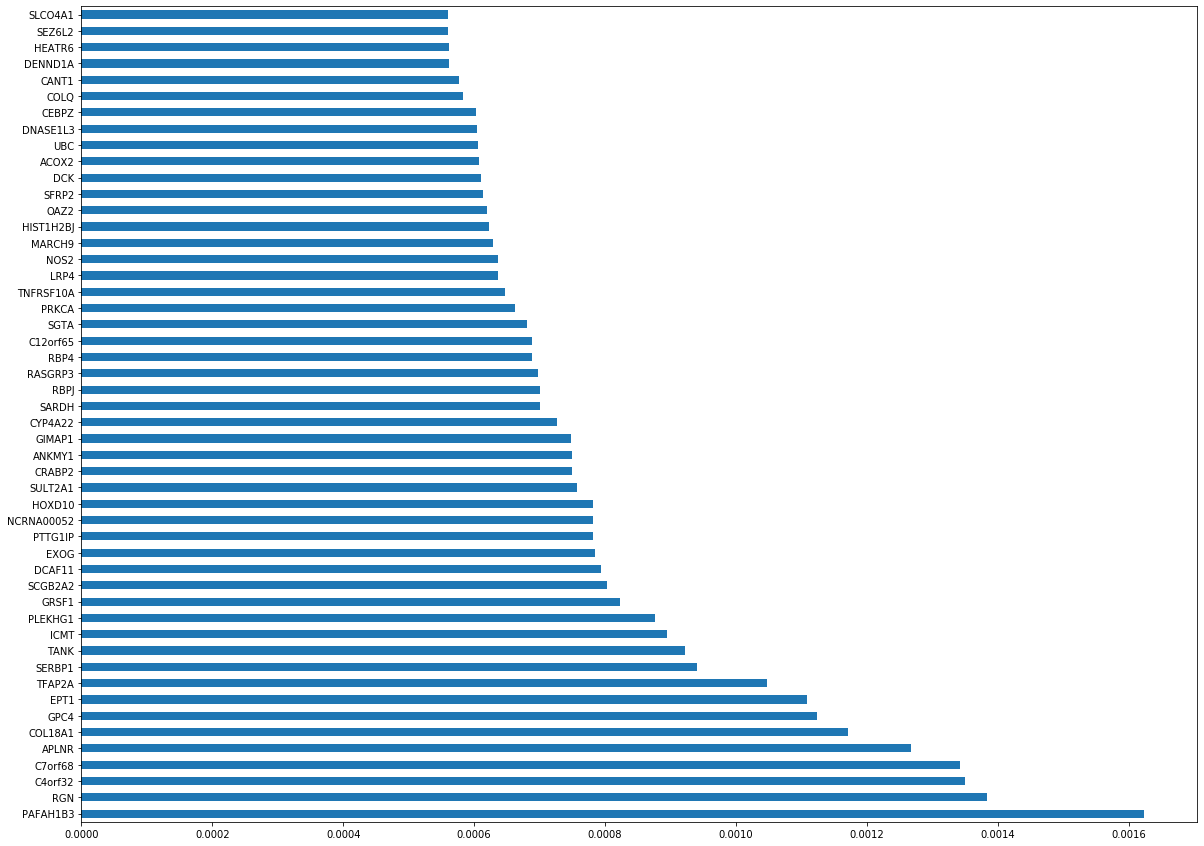

In [0]:
from matplotlib import pyplot as plt

random_forest_best_feature_importances = rscv.best_estimator_['classifier'].feature_importances_
feature_importances_series = pd.Series(random_forest_best_feature_importances, index=rnaseq_x.columns)
feature_importances_series.nlargest(50).plot(figsize=(20, 15), kind='barh')

As we can see from the top 50 largest feature importance percentages, the gene PAFAH1B3 has the biggest by far with a percentage of ~0.16. I mainly wanted to visualize this to show off the range of percentages of feature relevance we are dealing in the dataset to set up my reasoning for using a small percentage for SelectPercentile. Due to the fact that we are dealing with 20,000+ features and the most relevant feature has a feature relevance percentage of 0.16%, we'll just consider the top 10% of features, as anything below that threshold will be too irrelevant for model prediction and evaluation. 

I'll be reusing the same code for the SelectFromModel process as from before

In [0]:
from sklearn.feature_selection import SelectPercentile 


sfm = SelectPercentile(percentile=10)
sfm.fit(rnaseq_x_train, tumor_y_train)

rnaseq_x_important_train = sfm.transform(rnaseq_x_train)
rnaseq_x_important_test = sfm.transform(rnaseq_x_test)

grid_search_2 = grid_search_process(rnaseq_x_important_train, tumor_y_train)
print("Best parameters:\n{}\n".format(grid_search_2.best_params_['classifier']))
print("Best cross-validation score: {:.2f}%".format(grid_search_2.best_score_*100))
print("Test-set score: {:.2f}%".format(grid_search_2.score(rnaseq_x_important_test, tumor_y_test)*100))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [3711 3902] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Best parameters:
SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='squared_hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None,
              penalty='elasticnet', power_t=0.5, random_state=None,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False)

Best cross-validation score: 52.05%
Test-set score: 40.57%


In [0]:
clf_best_2 = grid_search_2.best_params_['classifier']
filename = 'clf_best_2.sav'
clfb_saved_2 = pickle.dump(clf_best, open(filename, 'wb'))
clfb_loaded_2 = pickle.load(open(filename, 'rb'))

In [0]:
import pickle 
hallmark_dict = pickle.load(open('hallmarks_of_cancer_geneset_dictionary.pkl','rb'))
hallmark_dict

In [31]:
hallmark_gene_arr = []
for hallmark, arr in hallmark_dict.items(): 
    for gene in arr:
        if gene not in hallmark_gene_arr:
            hallmark_gene_arr.append(gene)

len(hallmark_gene_arr)

4384

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
rnaseq_x_scaled = scaler.fit_transform(rnaseq_x)
rnaseq_x_scaled_df = pd.DataFrame(rnaseq_x_scaled, columns=rnaseq_x.columns)

In [53]:
def feature_selector(features_to_select, df): 
    new_df = pd.DataFrame()
    for features in features_to_select: 
        if features in df.columns: 
            new_df[features] = df[features].values
    return new_df

rnaseq_x_important_df = feature_selector(hallmark_gene_arr, rnaseq_x_scaled_df)

rnaseq_x_important_df.head()

,ABCA1,ABCB8,ACAA2,ACADL,ACADM,ACADS,ACLY,ACO2,ACOX1,ADCY6,ADIG,ADIPOQ,ADIPOR2,AGPAT3,AIFM1,AK2,ALDH2,ALDOA,ANGPT1,ANGPTL4,APLP2,APOE,ARAF,ARL4A,ATL2,ATP1B3,BAZ2A,BCKDHA,BCL2L13,BCL6,C3,CAT,CCNG2,CD151,CD302,CD36,CDKN2C,CHCHD10,CHUK,CIDEA,...,FMO3,G6PC,GART,GCKR,GSS,GSTA3,GSTM4,GSTT2,HES6,HGFAC,HSD17B2,ITIH4,LCAT,LEAP2,LONP1,MAN1A1,MARCH6,MCCC2,MPP2,MTHFD1,NDRG2,NFS1,PGD,PGRMC1,PINK1,PTGDS,PTGR1,PYCR1,SAR1B,SERTAD1,SLC12A4,SLC22A1,SLC35B1,SLC46A3,SPINT2,SSR3,TAT,TTPA,UPB1,XDH
0,0.112687,0.244824,0.078362,0.001562,0.110534,0.055461,0.154196,0.044438,0.088356,0.462379,0.000000,0.0,0.044462,0.089493,0.224348,0.522482,0.072007,0.158206,0.103960,0.055616,0.132524,0.028749,0.121566,0.054222,0.120760,0.308798,0.572880,0.064124,0.336421,0.107969,0.188416,0.031602,0.273785,0.167536,0.022404,0.008626,0.126579,0.072634,0.385370,0.000000,...,0.008149,0.013308,0.181429,0.148601,0.291978,0.000000,0.000000,0.002653,0.099476,0.091214,0.090436,0.141358,0.005497,0.045287,0.228773,0.132101,0.154349,0.262480,0.001776,0.025551,0.049251,0.110994,0.151012,0.036188,0.144204,0.002201,0.078377,0.185072,0.233004,0.324395,0.112987,0.000340,0.129563,0.039149,0.011640,0.236940,0.001029,0.039581,0.124305,0.044273
1,0.123808,0.293219,0.223537,0.323790,0.263965,0.074630,0.197000,0.091618,0.216338,0.252733,0.085714,0.0,0.130969,0.459302,0.133433,0.422812,0.188774,0.076643,0.183168,0.001901,0.198249,0.067299,0.289094,0.023009,0.396201,0.156341,0.295771,0.101417,0.630424,0.120064,0.143990,0.305200,0.118412,0.111742,0.123387,0.049348,0.147067,0.118334,0.248869,0.000000,...,0.143489,0.015301,0.458214,0.406446,0.156987,0.006061,0.068844,0.028800,0.119721,0.000084,0.087449,0.118334,0.006376,0.113949,0.092511,0.216354,0.363005,0.318551,0.008881,0.167116,0.152670,0.357180,0.404919,0.267851,0.262870,0.000604,0.166251,0.002443,0.325494,0.053891,0.183333,0.118157,0.111668,0.079798,0.061180,0.290386,0.061697,0.121047,0.210980,0.168736
2,0.337608,0.183230,0.182895,0.510672,0.293309,0.068658,0.088642,0.069463,0.259667,0.436334,0.000000,0.0,0.297871,0.476952,0.237166,0.415018,0.389192,0.036772,0.202970,0.454340,0.181322,0.087772,0.282295,0.004802,0.466418,0.062536,0.445783,0.081590,0.483667,0.169157,0.616688,0.441115,0.255989,0.096115,0.275982,0.042940,0.058939,0.072859,0.389140,0.000000,...,0.138759,0.253582,0.171786,0.299406,0.092151,0.000000,0.111585,0.004277,0.018499,0.188664,0.092241,0.385410,0.308267,0.126752,0.115416,0.311845,0.256431,0.408521,0.003552,0.220309,0.181846,0.124145,0.065559,0.630001,0.427294,0.001043,0.132606,0.004398,0.477075,0.039432,0.314069,0.441643,0.102669,0.558996,0.006301,0.125110,0.259195,0.184084,0.205628,0.429494
3,0.180436,0.354037,0.168658,0.004685,0.287979,0.249829,0.182423,0.572977,0.268216,0.560450,0.000000,0.0,0.197999,0.653551,0.496592,0.225570,0.231784,0.089753,0.090759,0.094767,0.168779,0.199338,0.133805,0.037215,0.520014,0.045640,0.306875,0.260040,0.503657,0.102810,0.780287,0.170977,0.287474,0.035030,0.168734,0.021984,0.072130,0.198285,0.537707,0.000000,...,0.000231,0.226934,0.307500,0.123155,0.061386,0.000000,0.095154,0.000325,0.115183,0.620118,0.286692,0.137891,0.124157,0.314586,0.296860,0.358246,0.354226,0.490365,0.007105,0.186314,0.293429,0.645450,0.190259,0.421503,0.351567,0.000146,0.004955,0.131688,0.398024,0.038118,0.221645,0.123331,0.225483,0.096713,0.001635,0.406168,0.078347,0.025340,0.493415,0.692817
4,0.309464,0.182712,0.140735,0.476314,0.318310,0.235779,0.224890,0.064150,0.248125,0.216720,0.000000,0.0,0.307005,0.496366,0.089977,0.392986,0.275249,0.038208,0.064356,0.083231,0.170375,0.130072,0.206282,0.044418,0.532564,0.083511,0.311127,0.095005,0.437835,0.178762,0.564068,0.432811,0.158795,0.048988,0.242128,0.035693,0.027786,0.101544,0.470588,0.002515,...,0.145558,0.056640,0.226786,0.597455,0.062105,0.000000,0.057404,0.029450,0.046771,0.161539,0.059248,0.336699,0.269422,0.346433,0.154693,0.614038,0.318906,0.384606,0.007105,0.114473,0.213430,0.152025,0.091822,0.249900,0.215983,0.000046,0.096775,0.037503,0.353360,0.046004,0.27

In [0]:
rnaseq_x_train, rnaseq_x_test, tumor_y_train, tumor_y_test = train_test_split(rnaseq_x_important_df, np.ravel(tumor_y),
                                                                                 random_state=np.random.seed(0))
grid_search_3 = grid_search_process(rnaseq_x_train, tumor_y_train)
print("Best parameters:\n{}\n".format(grid_search_3.best_params_['classifier']))
print("Best cross-validation score: {:.2f}%".format(grid_search_3.best_score_*100))
print("Test-set score: {:.2f}%".format(grid_search_3.score(rnaseq_x_test, tumor_y_test)*100))

In [0]:
clf_best_3 = grid_search_3.best_params_['classifier']
filename = 'clf_best_3.sav'
clfb_saved_3 = pickle.dump(clf_best, open(filename, 'wb'))
clfb_loaded_3 = pickle.load(open(filename, 'rb'))

Since the accuracy scores that I'm getting through all three methods of feature extraction are below 50%, I'll be shifting strategies in how to extract features to get the best model predictive score. I'll now stick with using the hallmark gene dictionary to extract the features for each hallmark gene using the "feature selector" function created earlier. Then, I will be using the RandomForestClassifier model that I saved earlier to extract the best features. I'll be introducing Permutation Importance to visualized the best features per hallmark gene so we can see which features have a higher percentage of importance. 


In [0]:
!pip install eli5

In [109]:
import eli5
from eli5.sklearn import PermutationImportance
from IPython.core.display import display, HTML

rfb_loaded = pickle.load(open('random_forest_best.sav', 'rb'))
def train_hallmark(hallmark_gene, hallmark_arr, flag=False):
  new_df = feature_selector(hallmark_arr, rnaseq_x_scaled_df)
  new_df.name = hallmark_gene 
  #print(new_df.head())
  new_df_train, new_df_test, tumor_y_train, tumor_y_test = train_test_split(new_df, np.ravel(tumor_y), random_state=np.random.seed(0))
  rfb_model = rfb_loaded.fit(new_df_train, tumor_y_train)
  perm = PermutationImportance(rfb_model, random_state=1).fit(new_df_test, tumor_y_test)
  print(new_df.name + ":\n")
  perm_df = eli5.format_as_dataframe(eli5.explain_weights(perm, feature_names=new_df_test.columns.tolist(), top=50))
  if flag == True:
    return display(eli5.show_weights(perm, feature_names=new_df_test.columns.tolist(), top=50))
  else: 
    return perm_df
  

#let's display the first two trained datasets and their weights from PermutationImportance
count = 0 
for hallmark_gene, hallmark_arr in hallmark_dict.items(): 
  if count == 2:
    break 
  train_hallmark(hallmark_gene, hallmark_arr, True)
  count += 1 

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


HALLMARK_ADIPOGENESIS:



Weight,Feature
0.0226 ± 0.0092,DHRS7B
0.0132 ± 0.0092,CYC1
0.0132 ± 0.0192,PHYH
0.0113 ± 0.0141,ALDOA
0.0094 ± 0.0119,CAT
0.0094 ± 0.0169,DECR1
0.0094 ± 0.0119,GPAM
0.0075 ± 0.0141,REEP5
0.0075 ± 0.0075,ARL4A
0.0075 ± 0.0075,COX7B


HALLMARK_ALLOGRAFT_REJECTION:



Weight,Feature
0.0151 ± 0.0192,FAS
0.0151 ± 0.0092,HIF1A
0.0132 ± 0.0226,BCL10
0.0113 ± 0.0075,IFNGR1
0.0113 ± 0.0075,FLNA
0.0113 ± 0.0220,DARS
0.0094 ± 0.0000,GLMN
0.0094 ± 0.0000,CCL22
0.0094 ± 0.0000,GZMA
0.0094 ± 0.0169,HLA-DMA


Let's explain what is happening with the permutation importances. The weights are calculated by dividing the estimated error score from the permutation and the original feature importance score. So, the weights that are less than zero (not pictured here due to multiple features) can be discarded as it signifies that these features that the algorithm calculated are not considered important. In other words, for the hallmark gene Adipogenesis, the most important gene is DHRS7B. 

Therefore, I'll discard any features that are NOT in the green, meaning that the features with weights greater than 0 as well as choosing the top 10 features per hallmark gene from the permutation algorithm.

In [0]:
hallmark_columns = []
hallmark_mapped_features = {}
for hallmark_gene, hallmark_arr in hallmark_dict.items():
    perm_df = train_hallmark(hallmark_gene, hallmark_arr, False)
    filtered_perm_df = perm_df.head(10)
    hallmark_columns.append(list(filtered_perm_df['feature']))

In [150]:
import itertools
hallmark_columns = list(itertools.chain.from_iterable(hallmark_columns))
hallmark_columns_unique = list(set(hallmark_columns))
print("{} => {} => {}".format(len(rnaseq_x.columns), len(hallmark_columns), len(hallmark_columns_unique)))

20501 => 500 => 466


Now, I've gone from the original 20,000+ features to the processed  features from each hallmark gene which resulted in 1,559 features. We'll now select the features and start to train the new dataframe using the grid_search_process function. Afterwards, we'll compare the accuracy scores from all feature selection processes. 

In [165]:
rnaseq_x_important_hallmark_df = feature_selector(hallmark_columns_unique, rnaseq_x)
#We'll be using the MinMaxScaler in the grid_search_process function 
rnaseq_x_important_hallmark_df.head()

,MAPK14,PIM1,NADSYN1,COL5A1,NCAPH2,PIPOX,RHOD,DDB2,PHYH,GPAM,PCYT2,ERN1,AK3,RPN1,ENG,PARVA,HES1,UNG,IFNGR1,FAM126B,FLNA,GPC4,F3,GP9,DHCR7,HMGCL,ANGPTL4,HDAC5,ACVR1,IFI30,ABCB1,HKDC1,PDIA5,LDHC,ADAM10,F5,PBX2,FZD7,SQSTM1,STOM,...,CITED2,GJA1,NCSTN,IDO1,SOCS1,CLIC3,IRF2,RNF19A,CXCR4,CAPN5,CFB,GZMA,LAMC2,G0S2,GATA3,TNFAIP3,CNIH2,RAB31,PCNT,FOS,DECR1,JUN,NCAPH,F7,FSTL1,INHBE,PXMP2,HLA-C,RCL1,SORBS3,ZBP1,POLR2D,M6PR,PEX11B,NDUFV1,CCNL1,RBPJ,NFKBIA,COPE,XRCC6
0,772,659,1792,440,1491,469,1826,678,2470,543,1412,68,1745,9089,1381,331,774,879,1471,367,2956,316,45,0,4876,4104,1742,1867,603,12608,2058,2815,629,1,674,5397,1351,76,104919,5942,...,855,144,4116,700,273,55,1207,2631,2039,2118,19423,943,17,186,98,1545,12,375,449,1063,7161,1812,202,650,687,391,467,59745,343,1644,279,587,689,818,5184,1902,363,4187,6244,5931
1,1595,1716,1001,1119,1429,13982,931,403,8589,6820,3683,139,1946,12292,2031,863,1188,811,1269,270,11688,45,23,0,4722,4618,75,1692,674,4781,2698,901,1819,53,1608,16517,1296,96,61017,2264,...,540,247,2914,19,55,8,683,1784,224,2321,43397,60,102,1924,23,1498,5,372,901,784,4074,3355,436,2256,751,1250,2223,24984,295,1826,9,783,2023,833,6462,1388,225,2273,3090,7085
2,1757,656,1363,916,769,16983,914,770,5229,1872,2319,369,3352,8984,4278,845,561,589,1588,509,4939,30,11,0,3709,4578,14116,1304,670,5346,2848,335,3538,0,901,14535,1191,41,15001,9173,...,2687,666,2488,171,122,8,1210,1387,958,5035,248578,326,9,512,86,1399,9,303,749,545,5610,2235,65,4777,1304,2722,3219,102653,2122,2922,63,448,2077,817,3717,1447,253,4367,2896,3939
3,1533,252,697,147,822,2805,508,639,23391,8853,5382,235,3987,10698,2337,481,413,749,1141,514,2421,750,8,1,5396,4215,2957,810,400,2913,26,1617,2484,4,1386,27070,1832,23,12602,2470,...,1085,485,4262,48,17,1,685,841,189,4161,141342,55,9,2973,28,508,14,152,739,208,10747,1707,73,7474,931,4557,2402,18660,529,1650,1,481,1242,675,7432,1117,223,1615,6657,5750
4,3458,1336,1086,583,592,11566,1314,479,6344,5028,3874,260,5415,13448,4006,878,1050,580,2246,420,3000,6,9,0,5759,4573,2599,1106,326,2929,1468,1328,2112,2,1123,11089,1490,6,18290,9678,...,1611,677,2249,16,171,7,996,1330,794,4229,376789,117,17,7983,32,1826,6,356,677,5307,3528,6521,17,6189,1418,8918,3255,45100,1046,2176,13,430,1249,632,3066,2090,320,4635,2336,4491


In [152]:
rnaseq_x_hallmark_train, rnaseq_x_hallmark_test, tumor_y_train, tumor_y_test = train_test_split(rnaseq_x_important_hallmark_df, np.ravel(tumor_y),
                                                                                 random_state=np.random.seed(0))
grid_search_4 = grid_search_process(rnaseq_x_hallmark_train, tumor_y_train)
print("Best parameters:\n{}\n".format(grid_search_4.best_params_['classifier']))
print("Best cross-validation score: {:.2f}%".format(grid_search_4.best_score_*100))
print("Test-set score: {:.2f}%".format(grid_search_4.score(rnaseq_x_hallmark_test, tumor_y_test)*100))

Best parameters:
RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Best cross-validation score: 48.29%
Test-set score: 50.00%


In [0]:
clf_best_4 = grid_search_4.best_params_['classifier']
filename = 'clf_best_4.sav'
clfb_saved_4 = pickle.dump(clf_best_4, open(filename, 'wb'))
clfb_loaded_4 = pickle.load(open(filename, 'rb'))

In [0]:
!pip install shap

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


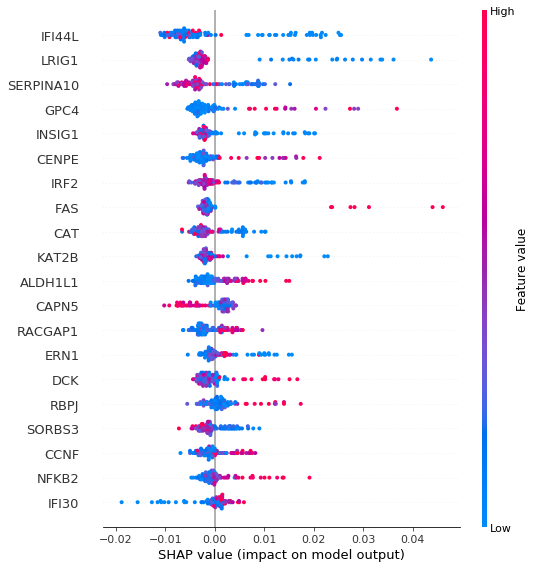

In [167]:
import shap
explainer = shap.TreeExplainer(clf_best)
shap_values = explainer.shap_values(rnaseq_x_hallmark_test)
shap.summary_plot(shap_values[1], rnaseq_x_hallmark_test)

In [228]:
hmf_values_concat = []
hmf_values_concat_feature = []
new_hallmark_gene_dict_with_feature = {}
new_hallmark_gene_dict_without_feature = {}
for gene, arr in hallmark_mapped_features.items(): 
  for arr0, arr1 in zip(arr[0], arr[1]):
    hmf_values_concat.append((arr0, arr1))
    hmf_values_concat_feature.append(arr1)
  new_hallmark_gene_dict_with_feature[gene] = hmf_values_concat
  new_hallmark_gene_dict_without_feature[gene] = hmf_values_concat_feature
  hmf_values_concat = []
  hmf_values_concat_feature = []
new_hallmark_mapped_without_features_df = pd.DataFrame.from_dict(new_hallmark_gene_dict_without_feature)
new_hallmark_mapped_without_features_df.head()

,HALLMARK_ADIPOGENESIS,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANGIOGENESIS,HALLMARK_APICAL_JUNCTION,HALLMARK_APICAL_SURFACE,HALLMARK_APOPTOSIS,HALLMARK_BILE_ACID_METABOLISM,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_COAGULATION,HALLMARK_COMPLEMENT,HALLMARK_DNA_REPAIR,HALLMARK_E2F_TARGETS,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,HALLMARK_ESTROGEN_RESPONSE_EARLY,HALLMARK_ESTROGEN_RESPONSE_LATE,HALLMARK_FATTY_ACID_METABOLISM,HALLMARK_G2M_CHECKPOINT,HALLMARK_GLYCOLYSIS,HALLMARK_HEDGEHOG_SIGNALING,HALLMARK_HEME_METABOLISM,HALLMARK_HYPOXIA,HALLMARK_IL2_STAT5_SIGNALING,HALLMARK_IL6_JAK_STAT3_SIGNALING,HALLMARK_INFLAMMATORY_RESPONSE,HALLMARK_INTERFERON_ALPHA_RESPONSE,HALLMARK_INTERFERON_GAMMA_RESPONSE,HALLMARK_KRAS_SIGNALING_DN,HALLMARK_KRAS_SIGNALING_UP,HALLMARK_MITOTIC_SPINDLE,HALLMARK_MTORC1_SIGNALING,HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V2,HALLMARK_MYOGENESIS,HALLMARK_NOTCH_SIGNALING,HALLMARK_OXIDATIVE_PHOSPHORYLATION,HALLMARK_P53_PATHWAY,HALLMARK_PANCREAS_BETA_CELLS,HALLMARK_PEROXISOME,HALLMARK_PI3K_AKT_MTOR_SIGNALING,HALLMARK_PROTEIN_SECRETION,HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,HALLMARK_SPERMATOGENESIS,HALLMARK_TGF_BETA_SIGNALING,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UV_RESPONSE_DN,HALLMARK_UV_RESPONSE_UP,HALLMARK_WNT_BETA_CATENIN_SIGNALING,HALLMARK_XENOBIOTIC_METABOLISM
0,0.022642,0.015094,0.016981,0.033962,0.007547,0.033962,0.016981,0.015094,0.018868,0.015094,0.028302,0.028302,0.026415,0.009434,0.028302,0.013208,0.016981,0.024528,0.013208,0.054717,0.020755,0.037736,0.009434,0.013208,0.018868,0.035849,0.011321,0.009434,0.016981,0.024528,0.016981,0.011321,0.062264,0.015094,0.033962,0.016981,0.020755,0.018868,0.024528,0.020755,0.020755,0.018868,0.028302,0.022642,0.035849,0.020755,0.018868,0.016981,0.039623,0.00566
1,0.013208,0.015094,0.013208,0.024528,0.007547,0.032075,0.016981,0.015094,0.016981,0.013208,0.028302,0.026415,0.022642,0.009434,0.028302,0.011321,0.015094,0.018868,0.011321,0.028302,0.018868,0.016981,0.007547,0.009434,0.013208,0.024528,0.009434,0.007547,0.016981,0.024528,0.016981,0.007547,0.037736,0.015094,0.013208,0.015094,0.020755,0.009434,0.020755,0.016981,0.018868,0.015094,0.026415,0.020755,0.015094,0.015094,0.018868,0.011321,0.024528,0.00000
2,0.013208,0.013208,0.011321,0.020755,0.007547,0.026415,0.015094,0.013208,0.016981,0.009434,0.022642,0.026415,0.020755,0.009434,0.028302,0.011321,0.015094,0.018868,0.009434,0.026415,0.016981,0.016981,0.005660,0.009434,0.011321,0.018868,0.009434,0.007547,0.015094,0.022642,0.016981,0.007547,0.035849,0.011321,0.011321,0.011321,0.018868,0.007547,0.020755,0.016981,0.015094,0.015094,0.022642,0.020755,0.011321,0.011321,0.016981,0.009434,0.018868,0.00000
3,0.011321,0.011321,0.011321,0.013208,0.007547,0.026415,0.013208,0.011321,0.016981,0.009434,0.018868,0.018868,0.018868,0.009434,0.024528,0.009434,0.013208,0.016981,0.009434,0.024528,0.016981,0.016981,0.005660,0.003774,0.011321,0.018868,0.009434,0.007547,0.015094,0.018868,0.016981,0.005660,0.033962,0.009434,0.005660,0.011321,0.018868,0.007547,0.018868,0.016981,0.013208,0.011321,0.022642,0.013208,0.011321,0.011321,0.015094,0.009434,0.016981,0.00000
4,0.009434,0.011321,0.011321,0.013208,0.007547,0.026415,0.013208,0.009434,0.013208,0.009434,0.018868,0.018868,0.018868,0.009434,0.022642,0.009434,0.011321,0.015094,0.007547,0.024528,0.016981,0.015094,0.005660,0.003774,0.011321,0.016981,0.007547,0.007547,0.015094,0.018868,0.016981,0.003774,0.033962,0.009434,0.005660,0.009434,0.018868,0.005660,0.016981,0.016981,0.013208,0.011321,0.020755,0.009434,0.009434,0.009434,0.013208,0.009434,0.016981,0.00000


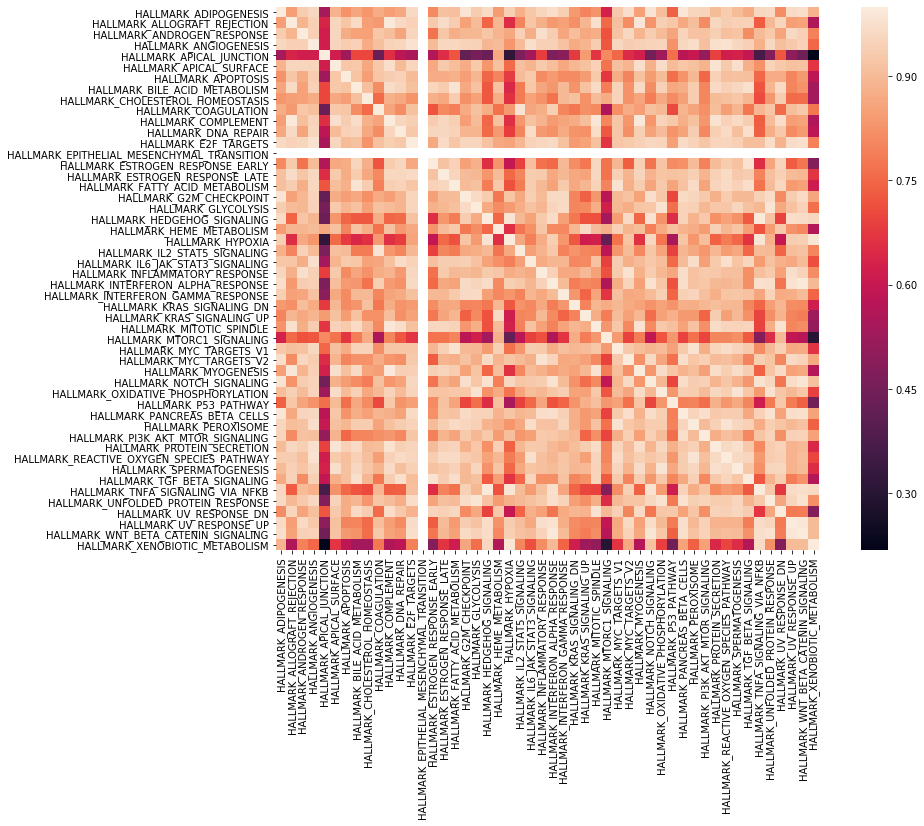

In [238]:
from matplotlib import pyplot as plt
import seaborn as sns

corr_matrix = new_hallmark_mapped_without_features_df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, mask=np.zeros_like(corr_matrix, dtype=np.bool), 
            xticklabels=corr_matrix.columns.values, yticklabels=corr_matrix.columns.values, square=True)

